In [ ]:
import os
import torch
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
from diffusion_lib import GaussianDiffusion
from plots import plot_2d
from torch.utils.data import TensorDataset, DataLoader

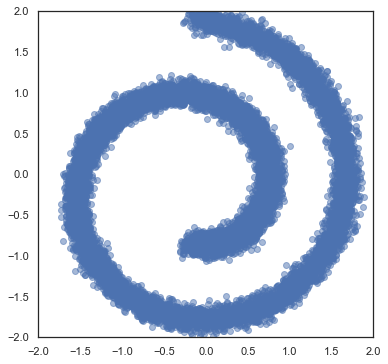

In [9]:
# Experiment settings
workdir = "./results/swiss/"
sample_dir = os.path.join(workdir, "samples")
os.makedirs(sample_dir, exist_ok=True)

# Generate Swiss Roll data
n_samples = 15000
x, _ = make_swiss_roll(n_samples, noise=0.5)
x = x[:, [0, 2]]  # Simplify to 2D
x = (x - x.mean()) / x.std()  # Normalize data
plot_2d(x, workdir, name="swiss_data", w=6, h=6, alpha=0.5, show=True)

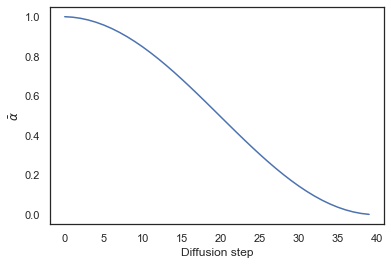

In [5]:
import seaborn as sns

diffusion_steps = 40  # Number of steps in the diffusion process

# Set noising variances betas as in Nichol and Dariwal paper (https://arxiv.org/pdf/2102.09672.pdf)
s = 0.008
timesteps = torch.arange(0, diffusion_steps, dtype=torch.float32)
schedule = torch.cos((timesteps / diffusion_steps + s) / (1 + s) * torch.pi / 2)**2

baralphas = schedule / schedule[0]
betas = 1 - baralphas / torch.cat([baralphas[0:1], baralphas[0:-1]])
alphas = 1 - betas

plt.plot(baralphas)
plt.xlabel("Diffusion step")
plt.ylabel(r"$\bar{\alpha}$")
plt.show()

In [10]:
dataset = torch.tensor(x, dtype=torch.float32)  # Convert to torch tensor

batch_size = 1024
trainset = TensorDataset(torch.Tensor(dataset))
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

batch = next(iter(trainloader))
x = batch[0]


In [11]:
diffusion = GaussianDiffusion(beta_min=0.0001, beta_max=0.020, T=100)

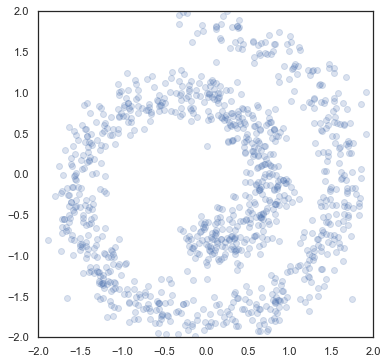

In [14]:
t = diffusion.T // 7
time_steps = torch.ones(x.shape[0]) * t
x_t, _ = diffusion.t_forward_steps(x, time_steps.long())
plot_2d(x_t, workdir, name="x_t", w=6, h=6, alpha=0.2, show=True)

In [15]:
from models_ import ResNetTabular

input_dim = 2
hidden_dim = 16
model = ResNetTabular(input_size=2, num_res_blocks=10)

In [44]:
import torch.nn as nn

class DiffusionBlock(nn.Module):
    def __init__(self, nunits):
        super(DiffusionBlock, self).__init__()
        self.linear = nn.Linear(nunits, nunits)

    def forward(self, x: torch.Tensor):
        x = self.linear(x)
        x = nn.functional.relu(x)
        return x


class DiffusionModel(nn.Module):
    def __init__(self, nfeatures: int, nblocks: int = 2, nunits: int = 64):
        super(DiffusionModel, self).__init__()

        self.inblock = nn.Linear(nfeatures+1, nunits)
        self.midblocks = nn.ModuleList([DiffusionBlock(nunits) for _ in range(nblocks)])
        self.outblock = nn.Linear(nunits, nfeatures)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        val = torch.hstack([x, t.unsqueeze(1)])  # Add t to inputs
        val = self.inblock(val)
        for midblock in self.midblocks:
            val = midblock(val)
        val = self.outblock(val)
        return val
    

model = DiffusionModel(nfeatures=2, nblocks=4)

device = "cpu"
model = model.to(device)

model

DiffusionModel(
  (inblock): Linear(in_features=3, out_features=64, bias=True)
  (midblocks): ModuleList(
    (0): DiffusionBlock(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
    (1): DiffusionBlock(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
    (2): DiffusionBlock(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
    (3): DiffusionBlock(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (outblock): Linear(in_features=64, out_features=2, bias=True)
)

In [45]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [46]:
num_epochs = 500
train_losses  = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x in trainloader:
        x = x[0]
        time_steps = torch.randint(0, diffusion.T, (x.shape[0],), device=x.device).float()
        x_t, noise = diffusion.t_forward_steps(x, time_steps.long())
        predicted_noise = model(x_t, time_steps)

        loss = torch.mean(torch.square(predicted_noise - noise))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.detach().item()
    train_losses.append(train_loss / len(trainloader))
    
    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 0.9251198172569275
Epoch 20, Loss: 0.7133661508560181
Epoch 40, Loss: 0.7470293045043945
Epoch 60, Loss: 0.6150168180465698
Epoch 80, Loss: 0.6754744052886963
Epoch 100, Loss: 0.6742253303527832
Epoch 120, Loss: 0.6402440667152405
Epoch 140, Loss: 0.6000417470932007
Epoch 160, Loss: 0.679667592048645
Epoch 180, Loss: 0.5788894295692444
Epoch 200, Loss: 0.6677375435829163
Epoch 220, Loss: 0.6240923404693604
Epoch 240, Loss: 0.6487694978713989
Epoch 260, Loss: 0.6485186815261841
Epoch 280, Loss: 0.5993330478668213
Epoch 300, Loss: 0.557488203048706
Epoch 320, Loss: 0.5765579342842102
Epoch 340, Loss: 0.6076457500457764
Epoch 360, Loss: 0.5559964179992676
Epoch 380, Loss: 0.5984110832214355
Epoch 400, Loss: 0.6295076012611389
Epoch 420, Loss: 0.5865229368209839
Epoch 440, Loss: 0.5738552808761597
Epoch 460, Loss: 0.7015185356140137
Epoch 480, Loss: 0.6204345226287842


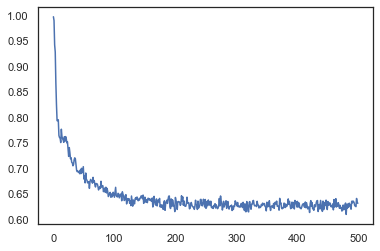

In [47]:
plt.plot(train_losses)

In [48]:
from sampling import AncestralSampling

shape = (1000, 2)
x = torch.randn(*shape)

model.eval()
sampler = AncestralSampling(diffusion, model) 
device="cpu"

In [49]:
from tqdm import tqdm

with torch.no_grad():
    # Initial sample - sampling from tractable prior
    x = diffusion.prior_sampling(shape).to(device)
    # reverse time partition [T, 0]
    timesteps = torch.flip(torch.arange(0, diffusion.T, device=device), dims=(0,))

    for i in tqdm(range(diffusion.N)):
        t = torch.ones(shape[0], device=device) * timesteps[i]
        # t = t.unsqueeze(1)  # remove
        x, x_mean = sampler.denoise_update_fn(x, t)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1163.48it/s]


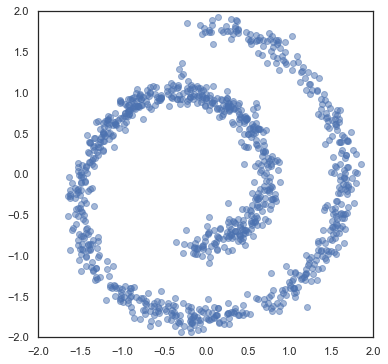

In [50]:
plot_2d(x, workdir, name="generated_swiss_data", w=6, h=6, alpha=0.5, show=True)